<a href="https://www.kaggle.com/code/nianiania/klasifikasi-brain-tumor-mri-cnn-dan-ano?scriptVersionId=292132137" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import random
from glob import glob
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
import time

In [2]:
def train_df(train_path):
    classes, class_paths = zip(*[(label, os.path.join(train_path, label, image))
                               for label in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, label))
                               for image in os.listdir(os.path.join(train_path, label))])

    train_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return train_df

In [3]:
def test_df(test_path):
    classes, class_paths = zip(*[(label, os.path.join(test_path, label, image))
                               for label in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, label))
                               for image in os.listdir(os.path.join(test_path, label))])

    test_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return test_df

In [4]:
df_train = train_df('/kaggle/input/brain-tumor-mri-dataset/Training')
df_train

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [5]:
df_test = test_df('/kaggle/input/brain-tumor-mri-dataset/Testing')
df_test

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


In [6]:
valid_data, test_data = train_test_split(df_test, train_size=0.8, random_state=32, stratify=df_test['Class'])
# valid_data = 80%
# test_data = 20%

In [7]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=10,
                                  brightness_range=(0.8, 1.2),
                                  width_shift_range=0.002,
                                  height_shift_range=0.002,
                                  shear_range=10,
                                  horizontal_flip=True,
                                  fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1/255)

train_gen = train_datagen.flow_from_dataframe(df_train, x_col='Class Path',
                                             y_col='Class', batch_size=32,
                                             target_size=(224, 224))
valid_gen = train_datagen.flow_from_dataframe(valid_data, x_col='Class Path',
                                             y_col='Class', batch_size=32,
                                             target_size=(224, 224))
test_gen = test_datagen.flow_from_dataframe(test_data, x_col='Class Path',
                                           y_col='Class', batch_size=32,
                                           target_size=(224, 224), shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 1048 validated image filenames belonging to 4 classes.
Found 263 validated image filenames belonging to 4 classes.


In [8]:
# Ant Nesting Optimization (ANO) Implementation
class AntNestingOptimizer:
    def __init__(self, param_grid, population_size=10, generations=5, evaporation_rate=0.5):
        self.param_grid = param_grid
        self.population_size = population_size
        self.generations = generations
        self.evaporation_rate = evaporation_rate
        self.best_params = None
        self.best_score = -np.inf
        
    class Nest:
        def __init__(self, params):
            self.params = params
            self.fitness = -np.inf
            self.pheromone = 1.0

    def initialize_population(self):
        self.population = []
        for _ in range(self.population_size):
            params = {k: random.choice(v) for k,v in self.param_grid.items()}
            self.population.append(self.Nest(params))

    def evaluate_fitness(self, nest, train_gen, valid_gen):
        # Build model with current parameters
        model = models.Sequential([
                                           
            layers.Flatten(),
            layers.Dense(nest.params['dense_units'], activation='relu'),
            layers.Dense(4, activation='softmax')
        ])
        #setiap dpt 1 model cnn
        model.compile(optimizer=Adam(learning_rate=nest.params['learning_rate']),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
        
        # Train with early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=2)
        history = model.fit(train_gen, 
                          validation_data=valid_gen,
                          epochs=nest.params['epochs'],
                          verbose=0,
                          callbacks=[early_stop])
        
        # Use validation accuracy as fitness
        nest.fitness = max(history.history['val_accuracy'])
        
        # Update best solution
        if nest.fitness > self.best_score:
            self.best_score = nest.fitness
            self.best_params = nest.params

    def update_pheromones(self):
        for nest in self.population:
            nest.pheromone = (1 - self.evaporation_rate) * nest.pheromone + nest.fitness

    def evolve_nests(self):
        sorted_nests = sorted(self.population, key=lambda x: x.fitness, reverse=True)
        for i in range(self.population_size):
            if random.random() < 0.7:  # Exploitation probability
                # Move towards better solutions
                leader = random.choice(sorted_nests[:3])
                new_params = {}
                for k in self.param_grid:
                    if isinstance(leader.params[k], float):
                        new_params[k] = np.clip(leader.params[k] + random.uniform(-0.1,0.1), 
                                              min(self.param_grid[k]),
                                              max(self.param_grid[k]))
                    else:
                        new_params[k] = leader.params[k]
            else:  # Exploration
                new_params = {k: random.choice(v) for k,v in self.param_grid.items()}
                
            self.population.append(self.Nest(new_params))
        
        # Keep only top population_size nests
        self.population = sorted(self.population, 
                               key=lambda x: x.pheromone, 
                               reverse=True)[:self.population_size]

    def optimize(self, train_gen, valid_gen):
        self.initialize_population()
        
        for gen in range(self.generations):
            print(f"Generation {gen+1}/{self.generations}")
            for nest in self.population:
                self.evaluate_fitness(nest, train_gen, valid_gen)
            self.update_pheromones()
            self.evolve_nests()
            
        return self.best_params

# Define parameter search space
param_grid = {
    'filters1': [32, 64, 128],
    'filters2': [64, 128, 256],
    'dense_units': [128, 256, 512],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'dropout': [0.3, 0.4, 0.5], #biar tidak overvitting 
    'epochs': [10, 15]
}

# Initialize and run ANO optimizer
ano_optimizer = AntNestingOptimizer(param_grid, population_size=5, generations=3)
best_params = ano_optimizer.optimize(train_gen, valid_gen)

print("Best parameters found:", best_params)

# Build final model with optimized parameters
# Build final model with optimized parameters
final_model = models.Sequential([
    layers.Conv2D(32, (1, 1), activation='relu', input_shape=(224, 224, 3), strides=1, padding='valid'),
    layers.Conv2D(64, (1, 1), activation='relu', strides=1, padding='valid'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=2),
    layers.Conv2D(64, (2, 2), activation='relu', strides=1, padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', strides=1, padding='valid'),
    layers.Conv2D(128, (3, 3), activation='relu', strides=1, padding='valid'),
    layers.MaxPooling2D(pool_size=(5, 5), strides=2),
    layers.Conv2D(128, (3, 3), activation='relu', strides=1, padding='valid'),
    layers.Conv2D(128, (4, 4), activation='relu', strides=1, padding='valid'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=5),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),  # Adjusted to match dense_units
    layers.Dense(4, activation='softmax')   # Output layer remains the same
])



final_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train final model
history = final_model.fit(train_gen,
                        validation_data=valid_gen,
                        epochs=20,
                        callbacks=[EarlyStopping(patience=3)])

Generation 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Generation 2/3
Generation 3/3
Best parameters found: {'filters1': 32, 'filters2': 128, 'dense_units': 512, 'learning_rate': 0.0005, 'dropout': 0.3, 'epochs': 15}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 128s 601ms/step - accuracy: 0.5769 - loss: 0.9490 - val_accuracy: 0.7634 - val_loss: 0.5820
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 492ms/step - accuracy: 0.8132 - loss: 0.4851 - val_accuracy: 0.8321 - val_loss: 0.4331
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 494ms/step - accuracy: 0.8665 - loss: 0.3709 - val_accuracy: 0.8550 - val_loss: 0.3797
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 484ms/step - accuracy: 0.8886 - loss: 0.2894 - val_accuracy: 0.8989 - val_loss: 0.2696
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 481ms/step - accuracy: 0.9185 - loss: 0.2196 - val_accuracy: 0.8760 - val_loss: 0.3417
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 490ms/step - accuracy: 0.9325 - loss: 0.1913 - val_accuracy: 0.9437 - val_loss: 0.1724
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 492ms/step - accuracy: 0.9412 - loss: 0.1425 - val_accuracy: 0.9656 - val_loss: 0.1325
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 489ms/step - accuracy: 0.9598 - loss: 


Training History:
Final Training Accuracy: 0.9895
Final Validation Accuracy: 0.9800


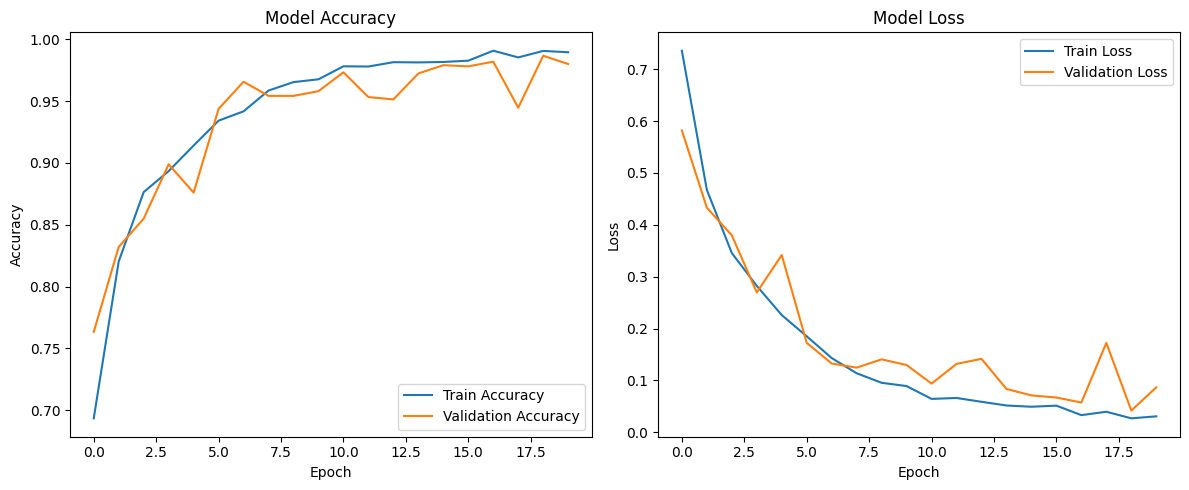


Test Set Evaluation:
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 0.9903 - loss: 0.0932
Test Accuracy: 0.9886
Test Loss: 0.1071
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00        60
  meningioma       0.97      0.98      0.98        62
     notumor       1.00      1.00      1.00        81
   pituitary       0.98      0.97      0.97        60

    accuracy                           0.99       263
   macro avg       0.99      0.99      0.99       263
weighted avg       0.99      0.99      0.99       263



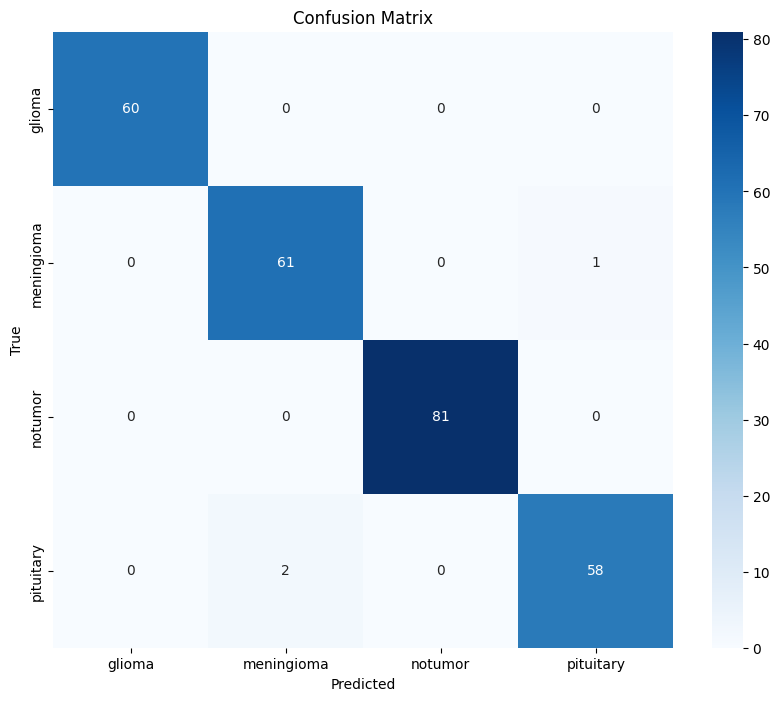


Optimization Results Summary:
Best Parameters Found:
- filters1: 32
- filters2: 128
- dense_units: 512
- learning_rate: 0.0005
- dropout: 0.3
- epochs: 15

Validation Accuracy with Best Parameters: 0.7805
Final Test Accuracy: 0.9886


In [9]:
#Print training model

# 1. Print training history
print("\nTraining History:")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# 2. Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Evaluate on test set
print("\nTest Set Evaluation:")
test_loss, test_acc = final_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# 4. Confusion matrix

test_gen.reset()
preds = final_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

class_names = list(train_gen.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), 
            annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 5. Print best parameters and metrics
print("\nOptimization Results Summary:")
print("Best Parameters Found:")
for param, value in best_params.items():
    print(f"- {param}: {value}")
print(f"\nValidation Accuracy with Best Parameters: {ano_optimizer.best_score:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")